# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this project, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this project, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 51kB 7.8MB/s 


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
66.2MB [00:00, 108MB/s] 


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
    # filename: the name of the .csv file
    # max_vocab: The maximum number of words
    # max_len: 
    messages = []  # a list contains the reviews
    labels = []  # a list contains the labels
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        firstline = True
        for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

    tokenizer = Tokenizer(num_words=max_vocab)
    tokenizer.fit_on_texts(messages)
    messages_seq = tokenizer.texts_to_sequences(messages)
    data = pad_sequences(messages_seq, maxlen=max_len)  
    print('The messages after pad_sequences is', data)
    train_size = 0.8
    messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
    messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
    return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

The messages after pad_sequences is [[   1  661  139 ...   16  125  486]
 [   0    0    0 ... 1977   69  221]
 [   0    0    0 ...   63   16  350]
 ...
 [   0    0    0 ... 1957    2    2]
 [   0    0    0 ...   67  739   42]
 [   0    0    0 ...  794   11   17]]


Print one of the input in the training set.

In [ ]:
print(messages_train)
print('\nThe length of the training data is:', len(messages_train))
print('\n',messages_train[0])
print('\nThe length of the training data is:', len(messages_train[0]))

[[ 634   12  239 ...  156  206  352]
 [  10   37   97 ...   89  103    9]
 [   0    0    0 ...    2  712   64]
 ...
 [   0    0    0 ... 1611    2  601]
 [   0    0    0 ...  244  103  125]
 [   0    0    0 ...  481   70   72]]

The length of the training data is: 40000

 [ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68  

We print the first input of the messages_train. The length of this input is 200, which is consistent with max_len=200. As this input is a list, we can see every element in this input is an integer value in the range [0,2000], which is consistent with max_vocab=2000. The first a few elements are all 0, which is consistent with the default setting of pad_sequences that adds 0 to the head of a sequence whose length is less than max_len. In summary, it matches with what we expected.


# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

When the input is a sentence, the sentence can be seen as a matrix with lots of columns. The function \_\_init\_\_ then creates a truncated trainable matrix with much fewer columns by calling objax.nn.init.xavier_truncated_normal. The shape of the output matrix is specified by size and the latent is the lower truncation of the normal.

The \_\_call\_\_ function just returns the value of the truncated matrix.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this project, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

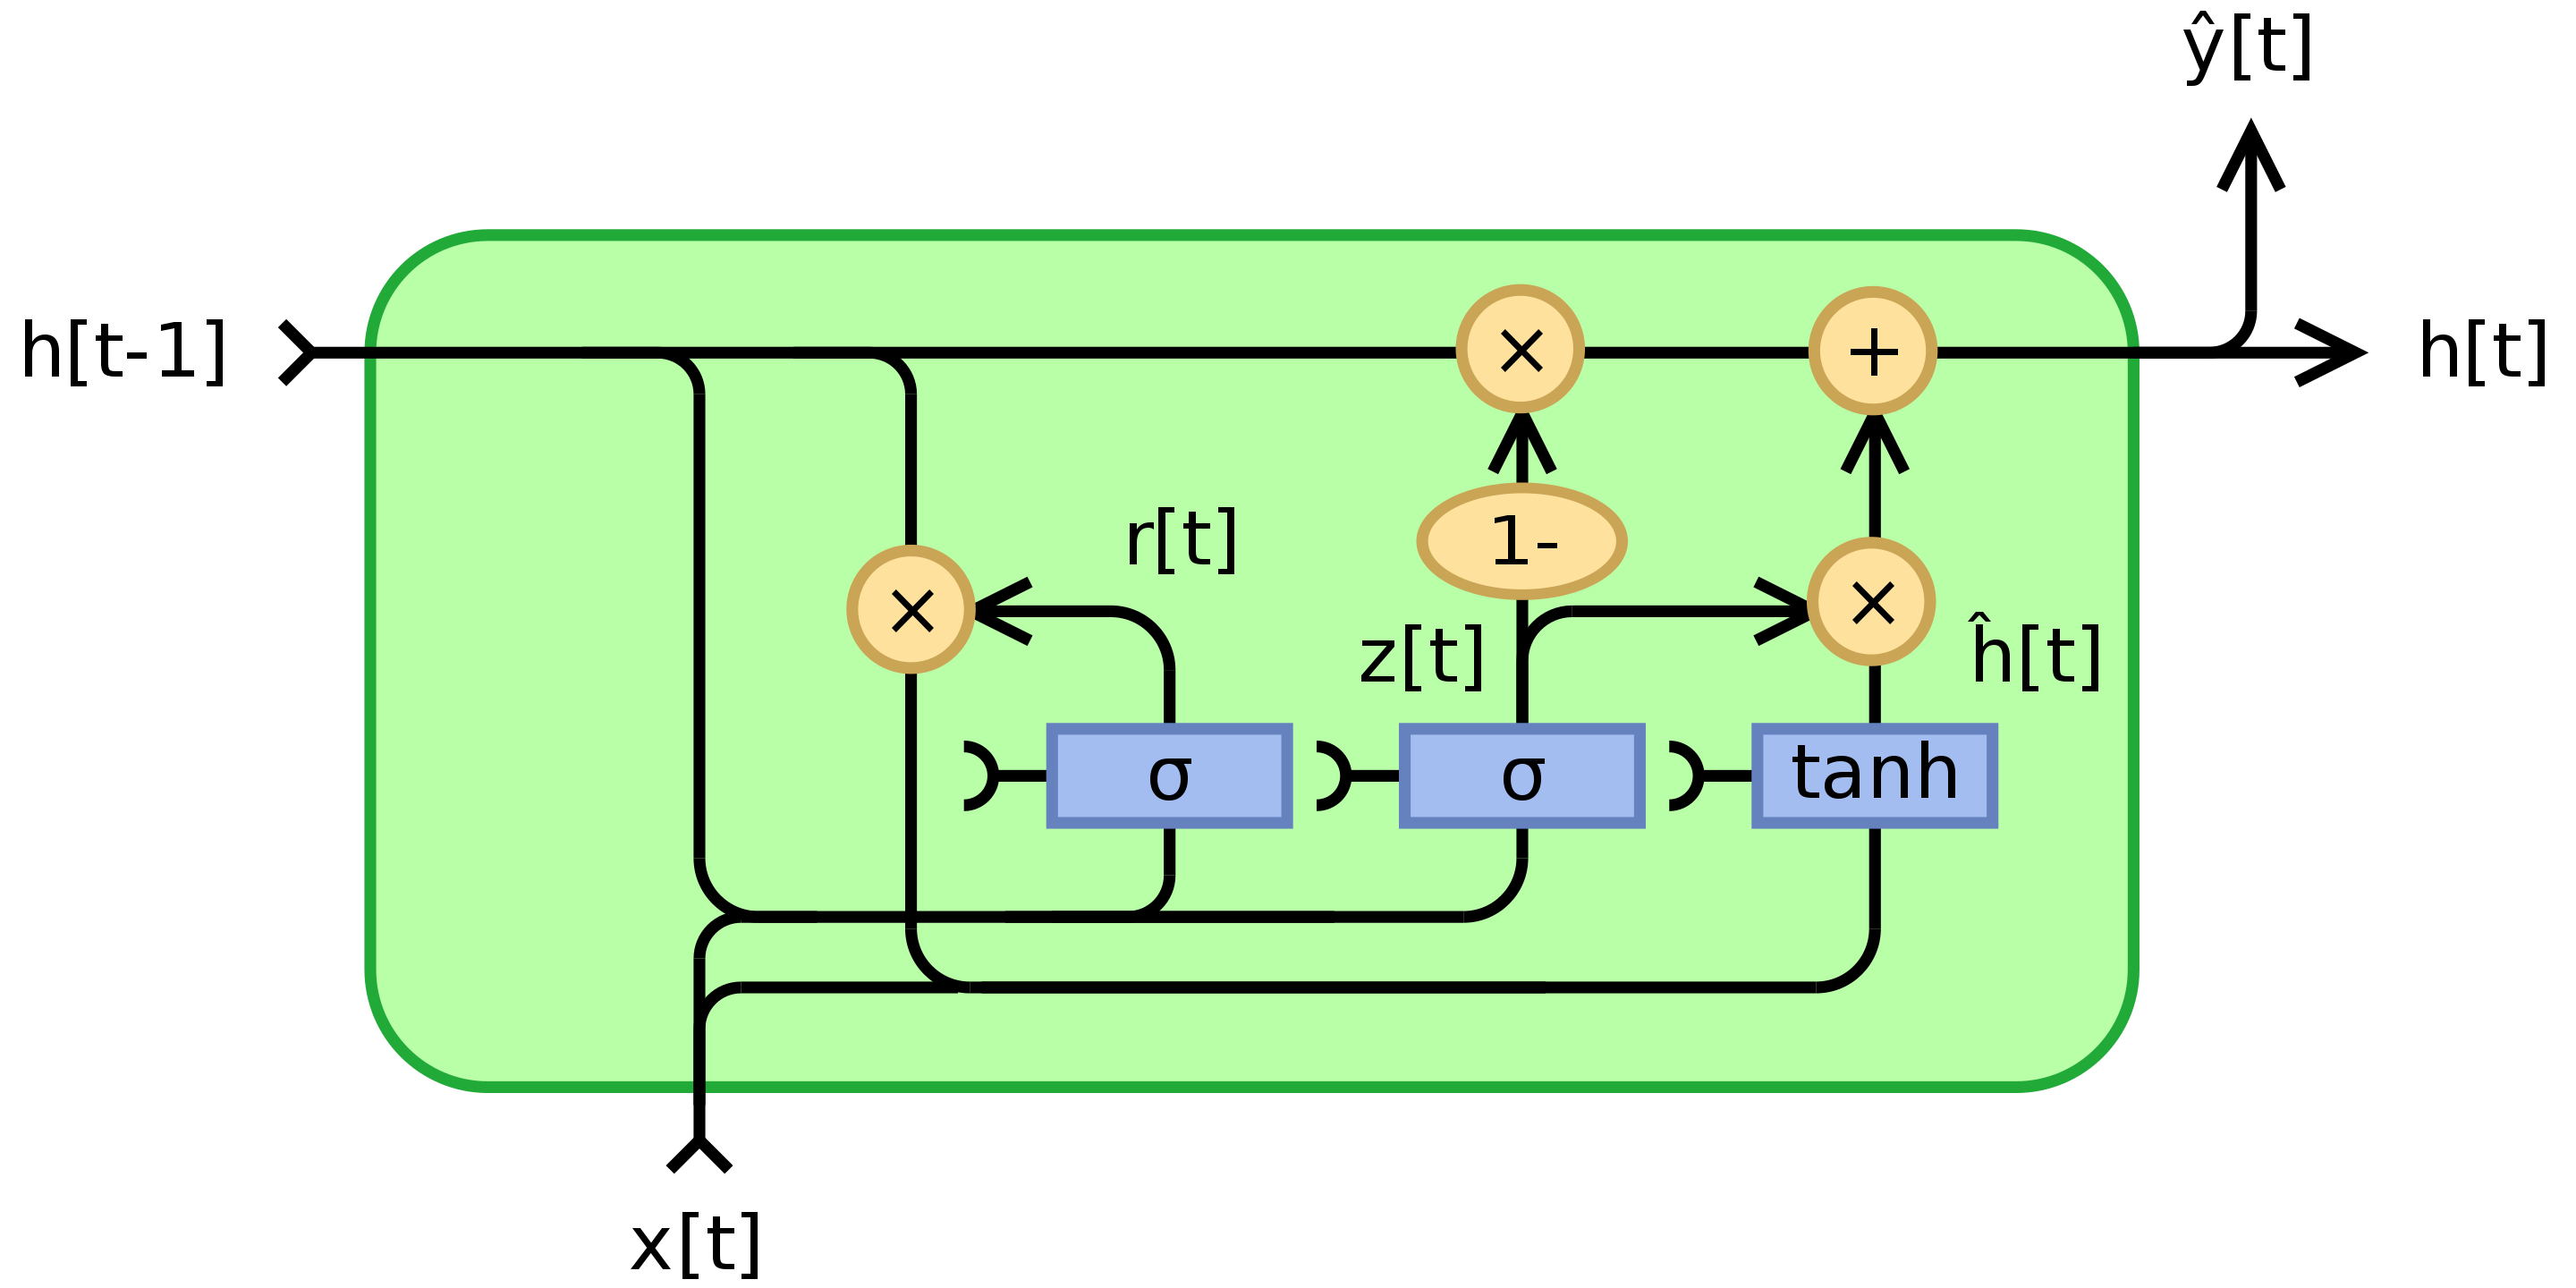

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x,self.update_w.value) + \
                                                   jn.dot(state,self.update_u.value) + \
                                                   self.update_b.value)

            reset_gate = objax.functional.sigmoid(jn.dot(x,self.reset_w.value) + \
                                                  jn.dot(state,self.reset_u.value) + \
                                                  self.update_b.value)
            
            output_gate = objax.functional.tanh(jn.dot(x,self.output_w.value) + \
                                                jn.dot((reset_gate*state),self.output_u.value) + \
                                                self.output_b.value)
            
            return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

### The lax.scan details

The lax.scan is used to scan a function over leading array axes while carrying along state. There are three mandatory arguments for lax.scan.

The first argument of lax.scan is a function 'f'. According to my understanding, this function f is kind of in a recursive flavour. The function f has two arguments where the first is a value of the loop carry and the second is a slice of an array or any pytree along its leading axis. The function f returns a pair where the first element represents a new value for the loop carry and the second represents a slice of the output. The lax.scan lets function f to use its first output as the next value of the loop carry.

The second argument of lax.scan is an initial loop carry value 'init' for the function f.

The third argument of lax.scan is the array or any pytree 'xs' that is also the second argument of f.


In [ ]:
def my_func(state, x):
  '''
  This function is very simple.
  The first output is state*x.
  The second output is state+x.
  '''
  return state*x, state+x

x = np.array([1,2,3,4,5])
initial_state = 1
(a, b) = lax.scan(my_func, initial_state, x)
print('The first output is:', a)
print('The second output is:', b)

# The state, the first output, and the second output are: 1,  1*1=1,    1+1=2
# The state, the first output, and the second output are: 1,  1*2=2,    1+2=3
# The state, the first output, and the second output are: 2,  2*3=6,    2+3=5
# The state, the first output, and the second output are: 6,  6*4=24,   6+4=10
# The state, the first output, and the second output are: 24, 24*5=120, 24+5=29

The first output is: 120
The second output is: [ 2  3  5 10 29]


### An running example
In the above example, we use lax.scan to scan the simple function 'my_func', which is also the first argument of the lax.scan above. The my_func is very simple. It has two arguments 'state' and 'x'. The my_func only does two operations and return them as outputs. The first output is state*x. The second output is state+x.

The initial value of the loop carry is set to 1. The array as sthe third argument of the lax.scan is np.array([1,2,3,4,5])

We can see that the output of the lax.scan are 120 and [2 3 5 10 29]. The outputs are as expected. We list the detailed evolution of the state, the first output, and the second output below.

The state, the first output, and the second output are: 1,  1*1=1(next state),    1+1=2

The state, the first output, and the second output are: 1,  1*2=2(next state),    1+2=3

The state, the first output, and the second output are: 2,  2*3=6(next state),    2+3=5

The state, the first output, and the second output are: 6,  6*4=24(next state),   6+4=10

The state, the first output, and the second output are: 24, 24*5=120(next state), 24+5=29

We can see that the first output of the last iteration is 120 and the second outputs along all the iterations are [2 3 5 10 29].

### What is it useful for
The lax.scan function is used for running recursive function. In NLP, we are dealing with sequential data, where data are indexed by time points. We do care the evolution of various vectors given the fixed evolution rule, e.g., the GRU cell. We typically use the output from at last time point as one of the input of the computation at the current time point. Then it is very natural to treat the running process of the cell along time points as a running process of a recursive function, where the output of the function is also the loop carry. That's why we use lax.scan here.

### Three optional arguments of lax.scan
The lax.scan also has three optional arguments: length, reverse, and unroll.

The 'length' specifies the number of loop iterations, which must agree with the sizes of leading axes of the arrays in xs.

The 'reverse' specifies whether to run the scan iteration forward (the default) or in reverse.

The 'unroll' specifies how many scan iterations to unroll within a single iteration of a loop.

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



In [ ]:
gru_rnn = objax.nn.Sequential([Embed(max_len, embedding_size), 
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


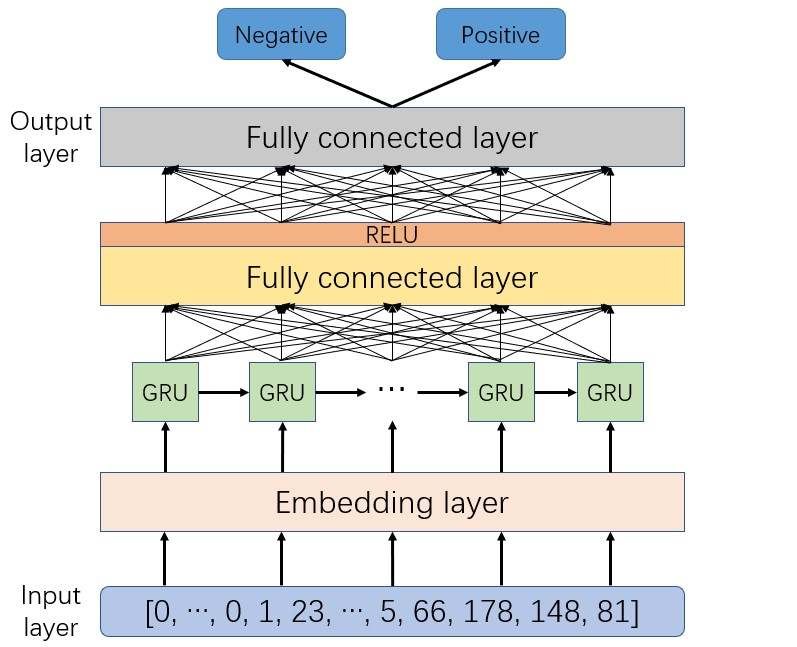

In [ ]:
## The SGD optimizer
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
print('The length of the training_data is:', len(training_data[0]))
x, y = training_data
epochs = []
acc_train = []
acc_valid = []
acc_test = 0
for ep in range(num_epochs):
    epochs.append(ep+1)
    train_indices = np.arange(len(messages_train))
    np.random.shuffle(train_indices)
    for it in range(0, len(messages_train), batch_size):
    batch = train_indices[it: it+batch_size]
    x_batch, target_class = x[batch], y[batch]
    train_op(x_batch, target_class, learning_rate)
    train_acc = accuracy(training_data)
    acc_train.append(train_acc)
    print('The training accuracy at epoch', ep+1, 'is:', train_acc)
    valid_acc = accuracy(validation_data)
    acc_valid.append(valid_acc)
    print('The validation accuracy at epoch', ep+1, 'is:', valid_acc)
acc_test = accuracy(test_data)
print('The test accuracy is:', acc_test)

The length of the training_data is: 40000
The training accuracy at epoch 1 is: 0.5256
The validation accuracy at epoch 1 is: 0.5428
The training accuracy at epoch 2 is: 0.542725
The validation accuracy at epoch 2 is: 0.5522
The training accuracy at epoch 3 is: 0.56217504
The validation accuracy at epoch 3 is: 0.5672
The training accuracy at epoch 4 is: 0.57865
The validation accuracy at epoch 4 is: 0.5716
The training accuracy at epoch 5 is: 0.62037504
The validation accuracy at epoch 5 is: 0.6194
The training accuracy at epoch 6 is: 0.62435
The validation accuracy at epoch 6 is: 0.6176
The training accuracy at epoch 7 is: 0.66632503
The validation accuracy at epoch 7 is: 0.6674
The training accuracy at epoch 8 is: 0.66475004
The validation accuracy at epoch 8 is: 0.66840005
The training accuracy at epoch 9 is: 0.66020006
The validation accuracy at epoch 9 is: 0.6552
The training accuracy at epoch 10 is: 0.66217506
The validation accuracy at epoch 10 is: 0.65940005
The training accurac

Plot the training accuracy and the validation accuracy versus the number of epochs.

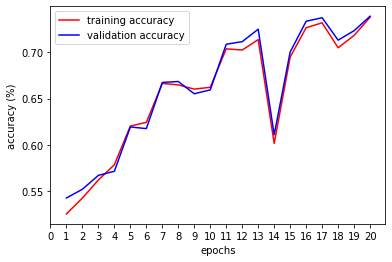


The generalization gap between the test and training is: -0.0050500035


In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc_train, 'r')
plt.plot(epochs, acc_valid, 'b')
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["training accuracy","validation accuracy"])
my_x_ticks = np.arange(0, 21, 1)
plt.xticks(my_x_ticks)
plt.show()
print('\nThe generalization gap between the test and training is:', acc_train[-1]-acc_test)

# Comparing SGD with Adam

Train the same model with the same parameters using the Adam optimizer instead of the SGD. Initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
gru_rnn2 = objax.nn.Sequential([Embed(max_len, embedding_size), 
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
print('The length of the training_data is:', len(training_data[0]))
x, y = training_data
epochs = []
acc_train = []
acc_valid = []
acc_test = 0
for ep in range(num_epochs):
    epochs.append(ep+1)
    train_indices = np.arange(len(messages_train))
    np.random.shuffle(train_indices)
    for it in range(0, len(messages_train), batch_size):
        batch = train_indices[it: it+batch_size]
        x_batch, target_class = x[batch], y[batch]
        train_op(x_batch, target_class, learning_rate)
    train_acc = accuracy(training_data)
    acc_train.append(train_acc)
    print('The training accuracy at epoch', ep+1, 'is:', train_acc)
    valid_acc = accuracy(validation_data)
    acc_valid.append(valid_acc)
    print('The validation accuracy at epoch', ep+1, 'is:', valid_acc)
acc_test = accuracy(test_data)
print('The test accuracy is:', acc_test)


The length of the training_data is: 40000
The training accuracy at epoch 1 is: 0.7289
The validation accuracy at epoch 1 is: 0.744
The training accuracy at epoch 2 is: 0.75307506
The validation accuracy at epoch 2 is: 0.75820005
The training accuracy at epoch 3 is: 0.75250006
The validation accuracy at epoch 3 is: 0.75460005
The training accuracy at epoch 4 is: 0.75942504
The validation accuracy at epoch 4 is: 0.7666
The training accuracy at epoch 5 is: 0.734475
The validation accuracy at epoch 5 is: 0.74120003
The training accuracy at epoch 6 is: 0.74472505
The validation accuracy at epoch 6 is: 0.7522
The training accuracy at epoch 7 is: 0.74420005
The validation accuracy at epoch 7 is: 0.75360006
The training accuracy at epoch 8 is: 0.74432504
The validation accuracy at epoch 8 is: 0.75020003
The training accuracy at epoch 9 is: 0.749175
The validation accuracy at epoch 9 is: 0.7558
The training accuracy at epoch 10 is: 0.75902504
The validation accuracy at epoch 10 is: 0.7638
The t

Plot the training accuracy and validation accuracy versus the epochs.

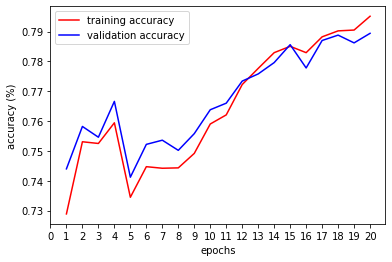


The generalization gap between the test and training is: 0.009125054


In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc_train, 'r')
plt.plot(epochs, acc_valid, 'b')
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["training accuracy","validation accuracy"])
my_x_ticks = np.arange(0, 21, 1)
plt.xticks(my_x_ticks)
plt.show()
print('\nThe generalization gap between the test and training is:', acc_train[-1]-acc_test)

Adam is an adaptive learning rate optimization algorithm. Adam uses the curvature information (obtained from the second order derivatives) of the loss function to improve the convergence of learning and helps find better solutions to the optimization problem faster. Adam uses the estimation of the first and the second moments of the gradients to speed up learning.

As a fine tuning algorithm, SGD is good but is also hard to get working out of the box if hyperparameters are not decided. 

By contrast, Adam uses second order information to improve the updates. Adam is much more likely to work well out of the box.

With sufficient computational resources, doing hyperparameter tuning with SGD might be able to find the parameters that work well.

# Early Stopping

The early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
gru_rnn3 = objax.nn.Sequential([Embed(max_len, embedding_size), 
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)    
])

In [ ]:
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
import copy

print('The length of the training_data is:', len(training_data[0]))
x, y = training_data
epochs = []
acc_train = []
acc_valid = []
acc_test = 0
best_valid_acc = 0
patience_flag = 0
# ckpt = objax.io.Checkpoint(logdir='ECE1513A6Jason', keep_ckpts=max_patience_window)
gru_copies = []

for ep in range(num_epochs):
    epochs.append(ep+1)
    train_indices = np.arange(len(messages_train))
    np.random.shuffle(train_indices)
    for it in range(0, len(messages_train), batch_size):
        batch = train_indices[it: it+batch_size]
        x_batch, target_class = x[batch], y[batch]
        train_op(x_batch, target_class, learning_rate)
    train_acc = accuracy(training_data)
    acc_train.append(train_acc)
    print('The training accuracy at epoch', ep+1, 'is:', train_acc)
    valid_acc = accuracy(validation_data)
    if acc_valid != [] and valid_acc <= best_valid_acc:
        patience_flag += 1
        # ckpt.save(gru_rnn3.vars(), idx=patience_flag)
    else:
        patience_flag = 0
        best_valid_acc = valid_acc
    acc_valid.append(valid_acc)
    print('The validation accuracy at epoch', ep+1, 'is:', valid_acc)
    if patience_flag >= max_patience_window:
        break
    gru_copies.append(copy.deepcopy(gru_rnn3))

The length of the training_data is: 40000
The training accuracy at epoch 1 is: 0.73590004
The validation accuracy at epoch 1 is: 0.74480003
The training accuracy at epoch 2 is: 0.75605005
The validation accuracy at epoch 2 is: 0.7602
The training accuracy at epoch 3 is: 0.74767506
The validation accuracy at epoch 3 is: 0.75380003
The training accuracy at epoch 4 is: 0.72682506
The validation accuracy at epoch 4 is: 0.725
The training accuracy at epoch 5 is: 0.73892504
The validation accuracy at epoch 5 is: 0.74320006
The training accuracy at epoch 6 is: 0.74972504
The validation accuracy at epoch 6 is: 0.75100005
The training accuracy at epoch 7 is: 0.755375
The validation accuracy at epoch 7 is: 0.7598


We can see that in the above outputs, at epoch 2, the validation accuracy is 0.7602. At epoch 3，4，5, 6, 7, the validation accuracy is lower than 0.7602. Thus, we stop the program early and use the parameters of the RNN at epoch 4. Therefore we use this model to obtain the test accuracy.

In [ ]:
# ckpt.restore(gru_rnn3.vars(), idx=1)
gru_rnn3 = gru_copies[-max_patience_window]
eval_op4 = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
def accuracy4(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op4(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [ ]:
accuracy_valid = accuracy4(validation_data)
print('The best validation accuracy of the best model is:', accuracy_valid)
acc_test = accuracy4(test_data)
print('The best test accuracy of the best model is:', acc_test)

The best validation accuracy of the best model is: 0.7602
The best test accuracy of the best model is: 0.75960004


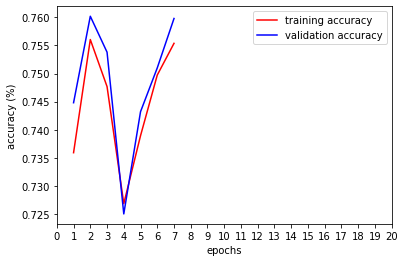

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc_train, 'r')
plt.plot(epochs, acc_valid, 'b')
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(["training accuracy","validation accuracy"])
my_x_ticks = np.arange(0, 21, 1)
plt.xticks(my_x_ticks)
plt.show()